In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import glob

import astropy.units as u
from astropy.constants import G, k_B, sigma_sb, m_p
plt.style.use('seaborn-white')
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u

from ombre.query import get_nexsci_df

In [6]:
df = get_nexsci_df()

/Users/ch/HST/projects/ombre/src/ombre/query.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["st_teff"][df.pl_hostname == "GJ 436"] = 3684.0


In [7]:
from astropy.utils.data import download_file
from astropy.constants import G, k_B, m_p
wk = pd.read_csv('wakeford-cat.csv')

planets = np.asarray(glob.glob('/Users/ch/HST/projects/ombre/notebooks/results/*'))
# planets = planets[~np.in1d(planets, 'results/HAT-P-11')]

# for idx in np.arange(6):
#     planets = planets[~np.in1d(planets, f'results/poly{idx}')]

    
# # These are proprietary
# planets = planets[~np.in1d(planets, 'results/GJ-9827b')]
# planets = planets[~np.in1d(planets, 'results/WASP-96')]
# planets = planets[~np.in1d(planets, 'results/L-98-59b')]
# planets = planets[~np.in1d(planets, 'results/L-98-59c')]
# planets = planets[~np.in1d(planets, 'results/polys')]
# planets = planets[~np.in1d(planets, 'results/old_temp')]
# planets = planets[~np.in1d(planets, 'results/GJ-9827b')]
# planets = planets[~np.in1d(planets, 'results/HD106315c')]
# planets = planets[~np.in1d(planets, 'results/LHS 1140b')]


n = np.sort([p.split('/')[-1] for p in planets])
df['names'] = [name.strip().lower().replace(' ', '').replace('-', '') for name in df['pl_hostname']]
st_teff = np.zeros(len(n))
st_rad = np.zeros(len(n))
st_mass = np.zeros(len(n))
pl_mass = np.zeros(len(n))
pl_rad = np.zeros(len(n))
pl_period = np.zeros(len(n))
for idx, n1 in enumerate(n):
    if n1.startswith('poly'):
        continue
    n2 = n1.strip().lower().replace(' ', '').replace('-', '')
    if not (n2[-1].isdigit()):
        n2 = n2[:-1]
    df1 = df[df.names == n2]
    if not n1[-1].isdigit():
        df1 = df1[df1.pl_letter == n1[-1]]
    df1 = df1.iloc[0]
    st_teff[idx] = df1['st_teff']
    st_rad[idx] = df1['st_rad']
    st_mass[idx] = df1['st_mass']
    pl_mass[idx] = df1['pl_bmassj']
    pl_rad[idx] = df1['pl_radj']
    pl_period[idx] = df1['pl_orbper']
#    break

st_teff[n == 'GJ436'] = 3684.0
st_teff[n == 'WASP-127'] = 5620.0
a = (((G * (st_mass * u.solMass + pl_mass*u.jupiterMass)/4*np.pi**2) * (pl_period*u.day)**2)**(1/3)).to(u.solRad)
Teq = st_teff*u.K*(st_rad/(2*a.value))**0.5
g = ((G * pl_mass*u.jupiterMass)/(pl_rad*u.jupiterRad)**2).to(u.m/u.s**2)
H = (k_B*Teq/(2 * m_p * g)).to(u.km)
cross_sec = (((pl_rad * u.jupiterRad) + 5*H)**2 - ((pl_rad * u.jupiterRad))**2).to(u.solRad**2)
delta_tran_dep = (((pl_rad * u.jupiterRad) + 5*H)**2 - ((pl_rad * u.jupiterRad))**2).to(u.solRad**2)/(st_rad * u.solRad)**2

df = pd.DataFrame(np.vstack([n, st_teff, pl_mass, pl_rad, a.value, Teq.value, g.value, H.value, st_rad, cross_sec.value, delta_tran_dep.value]).T)
spare = df[~np.in1d(df[0], wk['planet'])].reset_index(drop=True)
df = df.rename({0:'planet'}, axis='columns').merge(wk, how='inner').sort_values(10, ascending=False).reset_index(drop=True)

df['water'] = np.nan
df['water_err'] = np.nan

IndexError: single positional indexer is out-of-bounds

In [9]:
n

array(['HAT-P-1_stellar_spectrum.fits', 'HAT-P-1_transmission.fits',
       'WASP-79_stellar_spectrum.fits', 'WASP-79_transmission.fits',
       'WASP-80_stellar_spectrum.fits', 'WASP-80_transmission.fits',
       'WASP-96_stellar_spectrum.fits', 'WASP-96_transmission.fits',
       'XO-1_stellar_spectrum.fits', 'XO-1_transmission.fits',
       'XO-2_stellar_spectrum.fits', 'XO-2_transmission.fits',
       'noplanets'], dtype='<U29')

(-1, 6)

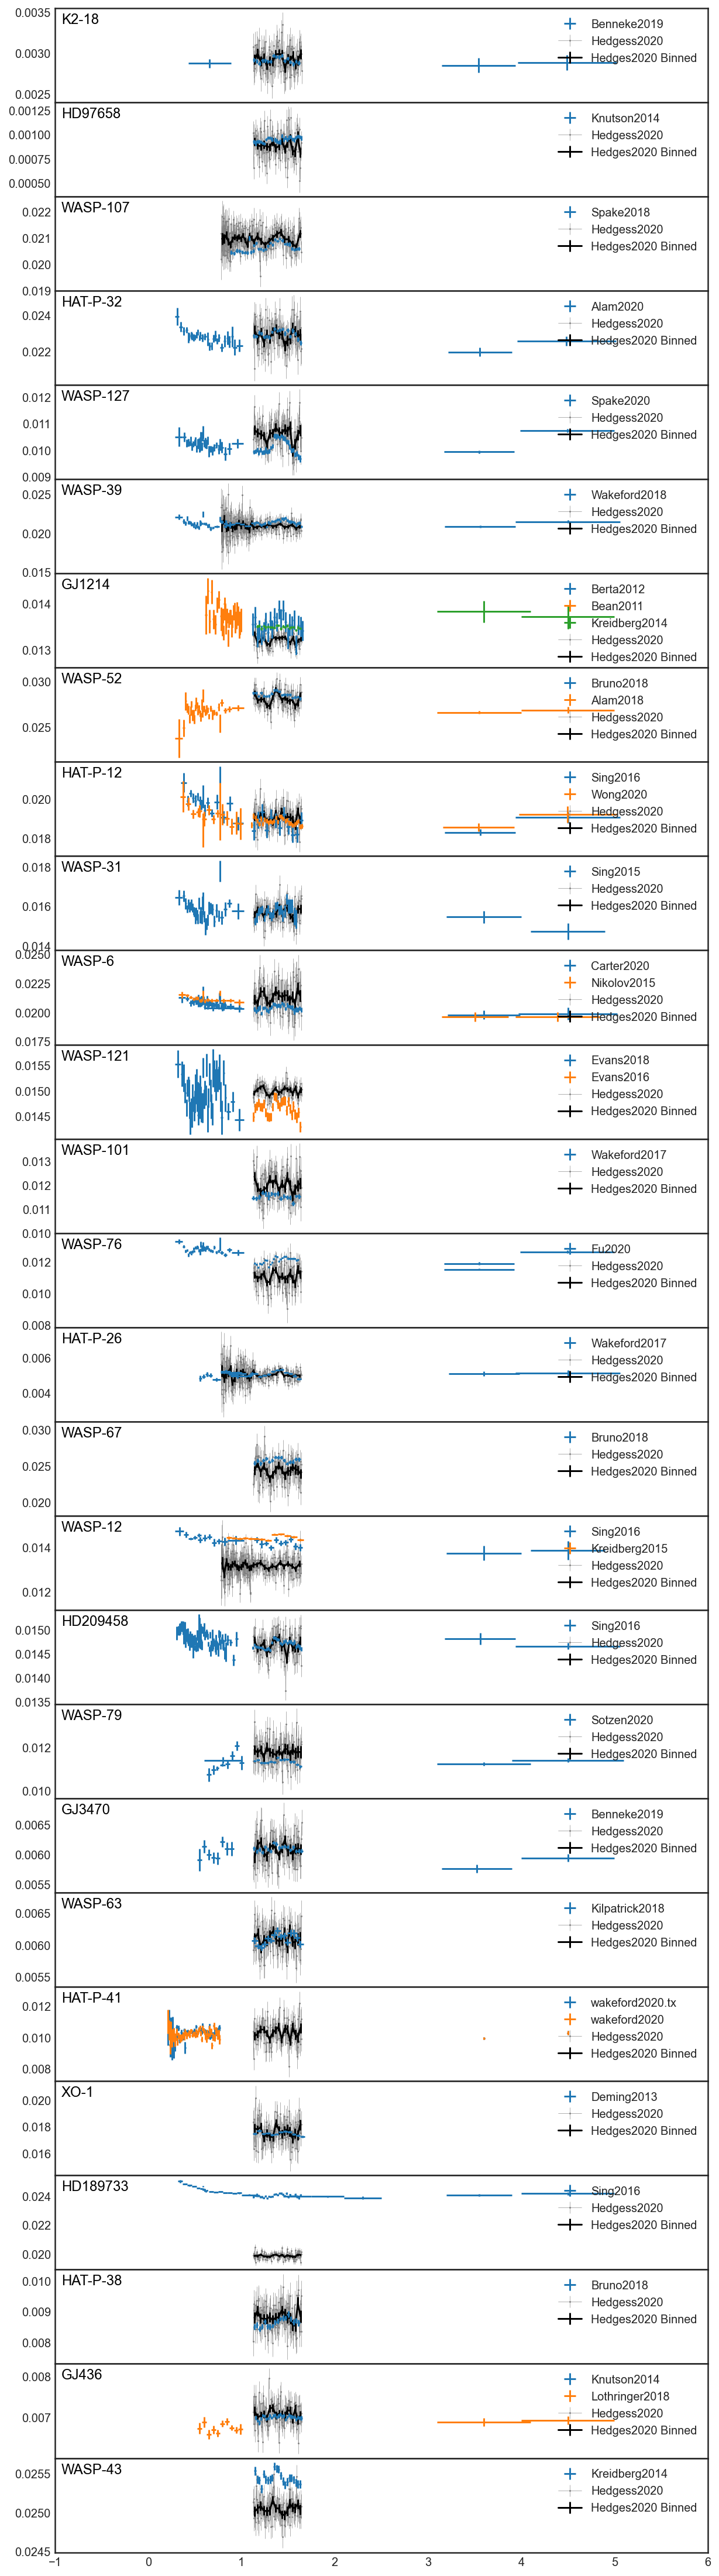

In [9]:
fig, axs = plt.subplots(len(df['planet'].unique()), 1, figsize=(10, 40), sharex=True, facecolor='white')
for ax, planet in zip(axs, df['planet'].unique()):
    idx = df.planet == planet
    if idx.sum() == 0:
        continue
    tdfs = []
    for url, name in zip(df['url'][idx], df['text'][idx]):
        dat = []
        for i in np.asarray(pd.read_csv(download_file(url, cache=True), error_bad_lines=False, warn_bad_lines=False, comment='#', header=None)):
            dat.append(np.asarray([float(j) for j in i[0].split(' ') if len(j) != 0]))
        tdf = pd.DataFrame(dat, columns=['wavelength', 'wavelength_err', 'transit_depth', 'transit_depth_err'])
        tdf['cite'] = name[:-4]
        tdfs.append(tdf)
    #tdf.columns=['wavelength', 'wavelength_err', 'transit_depth', 'transit_depth_err']
    
    for jdx, tdf in enumerate(tdfs):
#        tdf = tdf[(tdf.wavelength > 0.8) & (tdf.wavelength  < 1.7)]
        if len(tdf) == 0:
            continue
        ax.errorbar(tdf.wavelength, tdf.transit_depth, xerr=tdf.wavelength_err, yerr=tdf.transit_depth_err, ls='', c=f'C{jdx}', label=tdf.iloc[0]['cite'])
        k = (tdf.wavelength > 1.3) & (tdf.wavelength < 1.5)
        trend = np.polyval(np.polyfit(tdf.wavelength[~k], tdf.transit_depth[~k], 2), tdf.wavelength)
#        trend = np.nanpercentile(tdf.transit_depth, 5)
        trend = np.min(tdf.transit_depth)
        water = np.trapz((tdf.transit_depth[k] - trend)*1e6, tdf.wavelength[k])
        water_err = np.sum(((tdf.transit_depth_err * 1e6)**2)[k])**0.5
        df.loc[np.where(idx)[0][jdx], 'water'] = water
        df.loc[np.where(idx)[0][jdx], 'water_err'] = water_err
        
    r = pickle.load(open(f'results/{planet}/{planet}_results.p', 'rb'))
    w, t, te = r['transmission_wavelength'], r['transmission_spectrum'], r['transmission_spectrum_err']
    s = np.argsort(w)
    w, t, te = w[s], t[s], te[s]
    w *= 1e-4
    t *= 1e-6
    te *= 1e-6
    
    t += r['wl_map_soln']['ror']**2
    ax.errorbar(w, t, te, c='grey', lw=0.3, label='Hedgess2020', marker='.', ms=1, zorder=-10)
    m = np.asarray([np.in1d(np.arange(len(w)), i) for i in np.array_split(np.arange(len(w)), (w.max() - w.min())//0.03)])
    ax.errorbar([w[m1].mean() for m1 in m], [t[m1].mean() for m1 in m], [((te[m1]**2).sum()**0.5)/m1.sum() for m1 in m], c='k', label='Hedges2020 Binned', zorder=-5)
    
    ax.legend(loc='upper right')
    #ax.title(planet)
    ax.text(0.01, 0.95, f'{planet}',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='k', fontsize=12)
#    break
plt.subplots_adjust(hspace=0)

plt.xlim(-1,  6)

1

In [29]:
na = int(np.ceil(len(df['planet'].unique())/2))
nb = 2
for jdx in range(27):
#    print(jdx % na)
#    print(jdx % nb)
    print(int((jdx/na)), jdx % na)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12


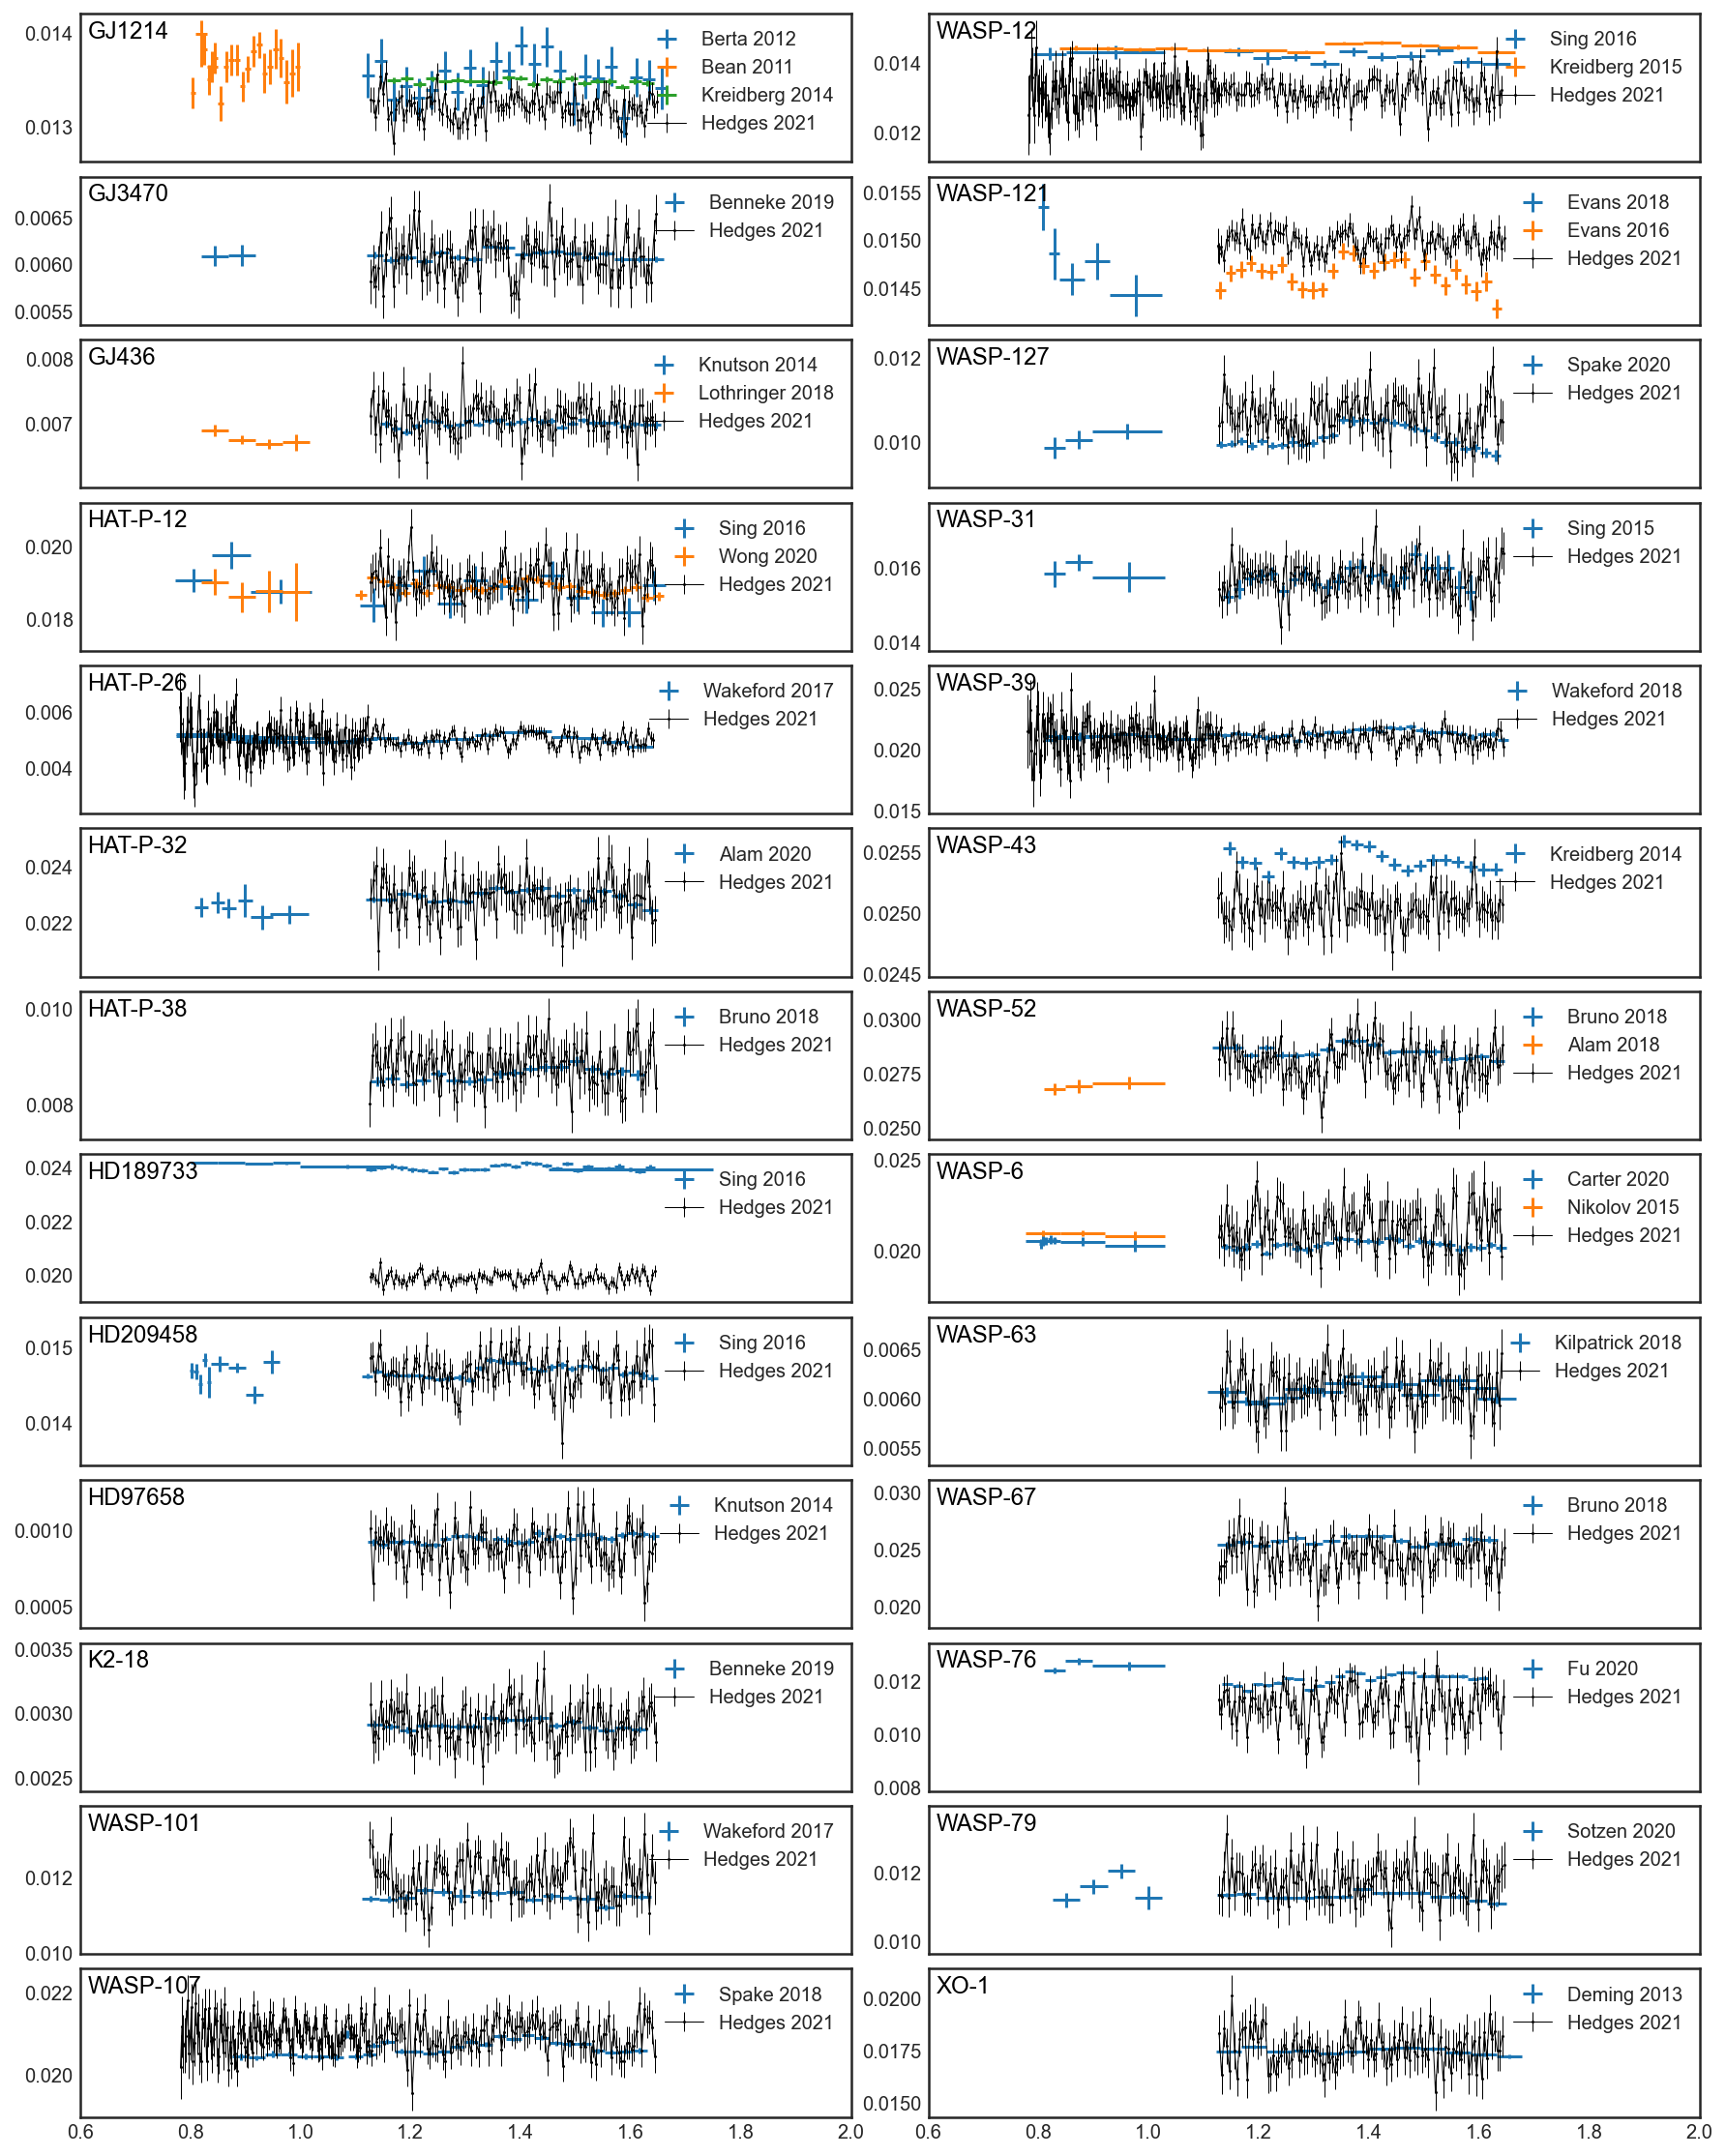

In [45]:
planets = df['planet'].unique()
planets = np.sort(planets[~np.in1d(planets, 'HAT-P-41')])
na = int(np.ceil(len(planets)/2))
nb = 2
fig, axs = plt.subplots(na, nb, figsize=(15, 20), sharex=True, facecolor='white')

for jdx, planet in enumerate(planets):
    ax = axs[jdx % na, int(jdx/na)]
    idx = df.planet == planet
    if idx.sum() == 0:
        continue
    tdfs = []
    for url, name in zip(df['url'][idx], df['text'][idx]):
        dat = []
        for i in np.asarray(pd.read_csv(download_file(url, cache=True), error_bad_lines=False, warn_bad_lines=False, comment='#', header=None)):
            dat.append(np.asarray([float(j) for j in i[0].split(' ') if len(j) != 0]))
        tdf = pd.DataFrame(dat, columns=['wavelength', 'wavelength_err', 'transit_depth', 'transit_depth_err'])
        tdf['cite'] = name[:-4]
        tdfs.append(tdf)
    #tdf.columns=['wavelength', 'wavelength_err', 'transit_depth', 'transit_depth_err']
    
    for jdx, tdf in enumerate(tdfs):
        tdf = tdf[(tdf.wavelength > 0.8) & (tdf.wavelength  < 1.7)]
        if len(tdf) == 0:
            continue
        ax.errorbar(tdf.wavelength, tdf.transit_depth, xerr=tdf.wavelength_err, yerr=tdf.transit_depth_err, ls='', c=f'C{jdx}', label='{0} {1}'.format(tdf.iloc[0]['cite'][:-4], tdf.iloc[0]['cite'][-4:]))
        k = (tdf.wavelength > 1.3) & (tdf.wavelength < 1.5)
        trend = np.polyval(np.polyfit(tdf.wavelength[~k], tdf.transit_depth[~k], 2), tdf.wavelength)
#        trend = np.nanpercentile(tdf.transit_depth, 5)
        trend = np.min(tdf.transit_depth)
        water = np.trapz((tdf.transit_depth[k] - trend)*1e6, tdf.wavelength[k])
        water_err = np.sum(((tdf.transit_depth_err * 1e6)**2)[k])**0.5
        df.loc[np.where(idx)[0][jdx], 'water'] = water
        df.loc[np.where(idx)[0][jdx], 'water_err'] = water_err
        
    r = pickle.load(open(f'results/{planet}/{planet}_results.p', 'rb'))
    w, t, te = r['transmission_wavelength'], r['transmission_spectrum'], r['transmission_spectrum_err']
    s = np.argsort(w)
    w, t, te = w[s], t[s], te[s]
    w *= 1e-4
    t *= 1e-6
    te *= 1e-6
    
    t += r['wl_map_soln']['ror']**2
    ax.errorbar(w, t, te, c='k', lw=0.5, label='Hedges 2021', marker='.', ms=1)
    
    ax.legend(loc='upper right')
    #ax.title(planet)
    ax.text(0.01, 0.95, f'{planet}',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='k', fontsize=12)
#    break
plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.xlim(0.6, 2)
plt.savefig('../../paper_ombre/figures/literature_comp.pdf', rasterized=True, bbox_inches='tight')
plt.savefig('../../paper_ombre/figures/literature_comp.png', dpi=200, bbox_inches='tight')

In [46]:
fort = pd.read_csv('fortney.dat', header=None, delimiter=' ')
fort[1] *= 1e6
fort[1] -= np.median(fort[1][(fort[0] > 1.1) & fort[0] < 1.7])
fort[1] /= np.std(fort[1][(fort[0] > 1.1) & fort[0] < 1.7])
fort[1] *= 0.6

def fit(w, t, te):
    dw = np.median(np.diff(w))
    smooth = convolve(fort[1], Gaussian1DKernel(20))
    model = np.zeros(w.shape)

    for kdx, w1 in enumerate(w):
        l = (fort[0] > (w1 - dw/2)) & (fort[0] <= (w1 + dw/2))
        model[kdx] = np.mean(smooth[l])
    
    fake_signal = model
#    plt.plot(fort[0], fort[1])
#    plt.plot(w, model)
#    plt.xlim(1.1, 1.7)
    
    X = np.hstack([fake_signal[:, None]**0])
    w_bf = np.linalg.solve(X.T.dot(X/te[:, None]**2), X.T.dot(t/te**2))
    w_bf_err = np.linalg.inv(X.T.dot(X/te[:, None]**2)).diagonal()**0.5
    m = X.dot(w_bf)
    chi0 = ((t - m)**2/te**2).sum(axis=0)/(len(te))

    X = np.hstack([fake_signal[:, None]**0, fake_signal[:, None]])
    w_bf = np.linalg.solve(X.T.dot(X/te[:, None]**2), X.T.dot(t/te**2))
    w_bf_err = np.linalg.inv(X.T.dot(X/te[:, None]**2)).diagonal()**0.5
    m = X.dot(w_bf)
    chi1 = ((t - m)**2/te**2).sum(axis=0)/(len(te) - 1)

    flat = chi0 < chi1 #* 1.01
    return w_bf[1], w_bf_err[1], flat, m

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy arr

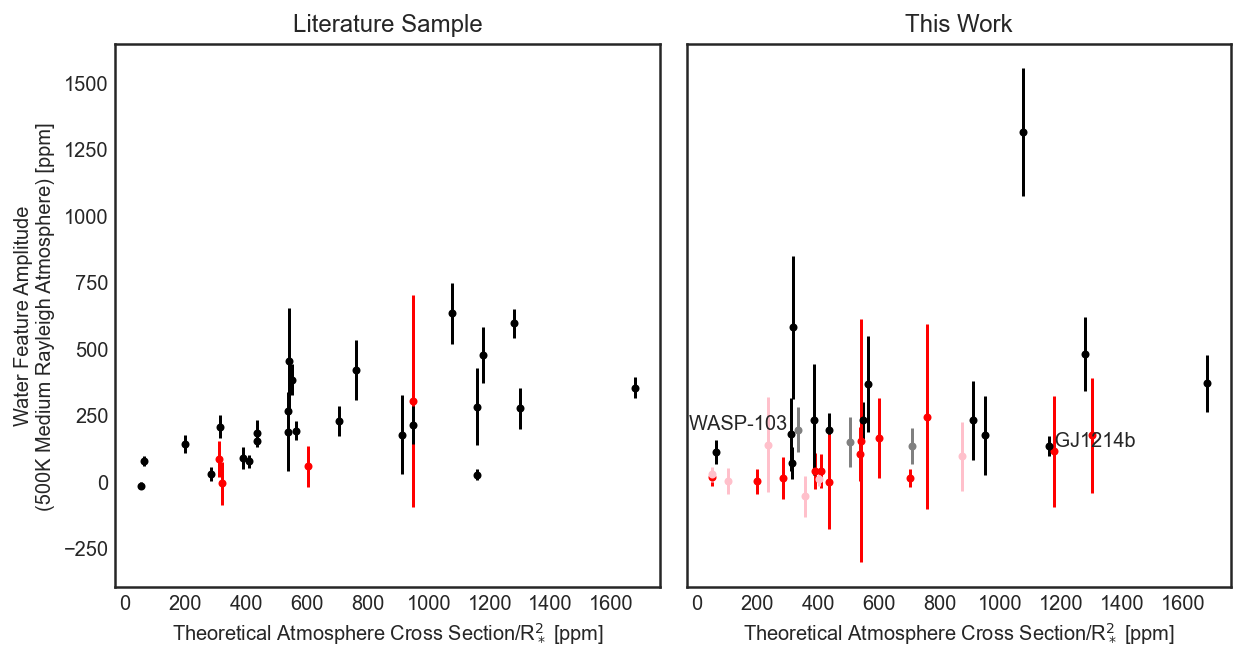

In [47]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, facecolor='white')
for planet in df['planet'].unique():
    idx = df.planet == planet
    if idx.sum() == 0:
        continue
    tdfs = []
    for url, name in zip(df['url'][idx], df['text'][idx]):
        dat = []
        for i in np.asarray(pd.read_csv(download_file(url, cache=True), error_bad_lines=False, warn_bad_lines=False, comment='#', header=None)):
            dat.append(np.asarray([float(j) for j in i[0].split(' ') if len(j) != 0]))
        tdf = pd.DataFrame(dat, columns=['wavelength', 'wavelength_err', 'transit_depth', 'transit_depth_err'])
        tdf['cite'] = name[:-4]
        tdfs.append(tdf)
    #tdf.columns=['wavelength', 'wavelength_err', 'transit_depth', 'transit_depth_err']
    
    for jdx, tdf in enumerate(tdfs):
        tdf = tdf[(tdf.wavelength > 1.1) & (tdf.wavelength  < 1.75)]
        if len(tdf) == 0:
            continue
        

        w, t, te = tdf.wavelength, tdf.transit_depth, tdf.transit_depth_err
        t *= 1e6
        te *= 1e6
        dw = np.median(np.diff(w))

        w_bf, w_bf_err, flat, model = fit(w, t, te)
        color='k'
        if flat:
            color='red'
        axs[0].errorbar(np.asarray(df[10][idx], float)[0] * 1e6, w_bf, w_bf_err, c=color, marker='.')
        
        df.loc[np.where(idx)[0][jdx], 'lit_corr'] = w_bf
        df.loc[np.where(idx)[0][jdx], 'lit_corr_err'] = w_bf_err
        df.loc[np.where(idx)[0][jdx], 'lit_flat'] = flat
        
        
    r = pickle.load(open(f'results/{planet}/{planet}_results.p', 'rb'))
    w, t, te = r['transmission_wavelength'], r['transmission_spectrum'], r['transmission_spectrum_err']
    s = np.isfinite(t)
    w, t, te = w[s], t[s], te[s]
    

    w /= 1e4
    
    w_bf, w_bf_err, flat, model = fit(w, t, te)

    df.loc[np.where(idx)[0], 'ch_corr'] = w_bf
    df.loc[np.where(idx)[0], 'ch_corr_err'] = w_bf_err
    df.loc[np.where(idx)[0], 'ch_flat'] = flat

        
    color='k'
    if flat:
        color='red'
    axs[1].errorbar(np.asarray(df[10][idx], float)[0] * 1e6, w_bf, w_bf_err, c=color, marker='.')

    

    
for planet in spare[0]:
    r = pickle.load(open(f'results/{planet}/{planet}_results.p', 'rb'))
    w, t, te = r['transmission_wavelength'], r['transmission_spectrum'], r['transmission_spectrum_err']
    s = np.isfinite(t) & np.isfinite(te) & np.isfinite(w)
    w, t, te = w[s], t[s], te[s]

    w /= 1e4
    w_bf, w_bf_err, flat, model = fit(w, t, te)

    color='grey'
    if flat:
        color='pink'
    axs[1].errorbar(np.asarray(spare[spare[0] == planet][10], float)[0] * 1e6, w_bf, w_bf_err, c=color, marker='.')
    spare.loc[spare[0] == planet, 'ch_corr'] = w_bf
    spare.loc[spare[0] == planet, 'ch_corr_err'] = w_bf_err
    spare.loc[spare[0] == planet, 'ch_flat'] = flat

    
#    print(w_bf)
#    break
    
#        break
#    break
axs[0].set(title="Literature") 
axs[1].set(title="This Work") 

k = df.planet == 'GJ1214'
axs[1].text(np.asarray(df[10], float)[k][0] * 1e6, np.asarray(df['ch_corr'][k])[0], ' GJ1214b')
k = spare[0] == 'WASP-103'
axs[1].text(np.asarray(spare[10], float)[k][0] * 1e6, np.asarray(spare['ch_corr'][k])[0], 'WASP-103  ', ha='right')


axs[0].set_ylabel("Water Feature Amplitude\n(500K Medium Rayleigh Atmosphere) [ppm]")
#ax[0].set_xlabel("Atmosphere Cross Section [R$_{sol}^2$]")
axs[0].set_xlabel("Theoretical Atmosphere Cross Section/R$_*^2$ [ppm]")
axs[1].set_xlabel("Theoretical Atmosphere Cross Section/R$_*^2$ [ppm]")
axs[0].set_title("Literature Sample")
axs[1].set_title("This Work")
plt.subplots_adjust(wspace=0.05)

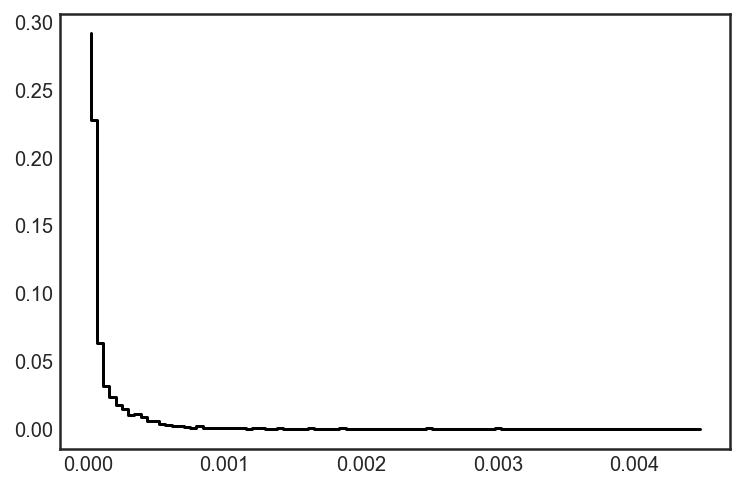

In [48]:
plt.figure()
h = np.histogram(all_df.delta_tran_dep, np.linspace(0, 0.0045, 100));
plt.step(h[1][1:] - np.median(np.diff(h[1]))/2, h[0]/len(all_df), color='k')

In [49]:
df[df.planet == 'GJ1214']

,planet,1,2,3,4,5,6,7,8,9,...,text,url,water,water_err,lit_corr,lit_corr_err,lit_flat,ch_corr,ch_corr_err,ch_flat
6,GJ1214,3026.0,0.0197,0.254,13.959344913044196,268.6165378209768,7.568578859199859,146.47850842874405,0.22,5.606501852565818e-05,...,Berta2012.txt,https://www.dropbox.com/s/tp6b5qk6gb1uxvy/GJ12...,103.900198,630.743992,281.862500,146.137403,False,132.096782,37.70398,False
7,GJ1214,3026.0,0.0197,0.254,13.959344913044196,268.6165378209768,7.568578859199859,146.47850842874405,0.22,5.606501852565818e-05,...,Bean2011.txt,https://www.dropbox.com/s/e6d2rdf3ns3smsx/GJ12...,0.000000,0.000000,NaN,NaN,NaN,132.096782,37.70398,False
8,GJ1214,3026.0,0.0197,0.254,13.959344913044196,268.6165378209768,7.568578859199859,146.47850842874405,0.22,5.606501852565818e-05,...,Kreidberg2014.txt,https://www.dropbox.com/s/iwsi6qrjhi39gmh/GJ12...,12.643801,83.707825,25.174184,20.199309,False,132.096782,37.70398,False


Text(0, 0.5, 'Water Feature Amplitude [ppm]')

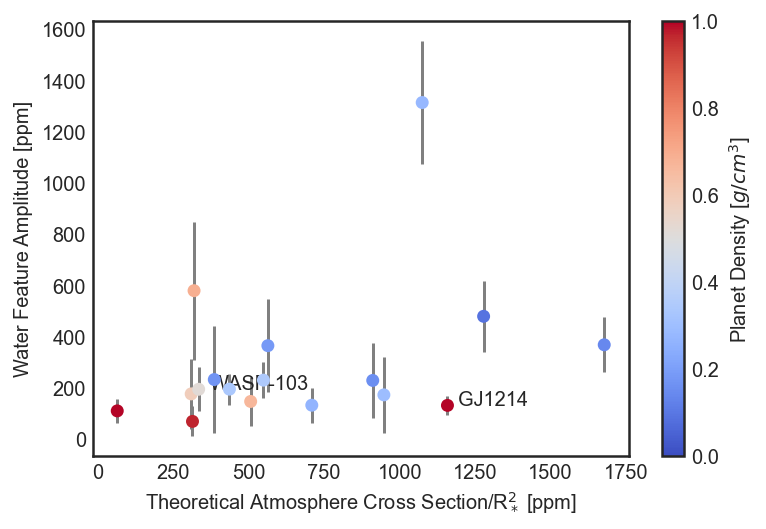

In [50]:
import astropy.units as u
plt.figure(facecolor='w')
df1 = pd.concat([df, spare.rename({0:'planet'}, axis='columns')]).drop_duplicates('planet').sort_values(10)
df1 = df1[df1['ch_flat'] == False].reset_index(drop=True)
density = np.asarray(df1[2], float) * u.jupiterMass / (4/3 * np.pi * (np.asarray(df1[3], float) * u.jupiterRad)**3)
density = density.to(u.g/u.cm**3)
#k = (df1['ch_flat'] == False)

for planet in ['GJ1214', 'WASP-103']:
    k = df1.planet == planet
    plt.text(np.asarray(df1[10], float)[k][0] * 1e6, np.asarray(df1['ch_corr'][k])[0], f'  {planet}')
#    break

plt.errorbar(np.asarray(df1[10], float) * 1e6, df1['ch_corr'], df1['ch_corr_err'], ls='', c='grey')    
plt.scatter(np.asarray(df1[10], float) * 1e6, df1['ch_corr'], s=30, c=density, zorder=10, cmap='coolwarm', vmin=0, vmax=1)
cbar = plt.colorbar()
cbar.set_label('Planet Density [$g/cm^3$]')
plt.xlabel("Theoretical Atmosphere Cross Section/R$_*^2$ [ppm]")
plt.ylabel("Water Feature Amplitude [ppm]")


In [51]:
df1 = pd.concat([df, spare.rename({0:'planet'}, axis='columns')]).drop_duplicates('planet').sort_values(10)
#df2 = df2[df2['ch_flat'] != False].reset_index(drop=True)
df1 = df1[(df1['ch_corr']/df1['ch_corr_err']) > 1.5].reset_index(drop=True)

(7000, 20000)

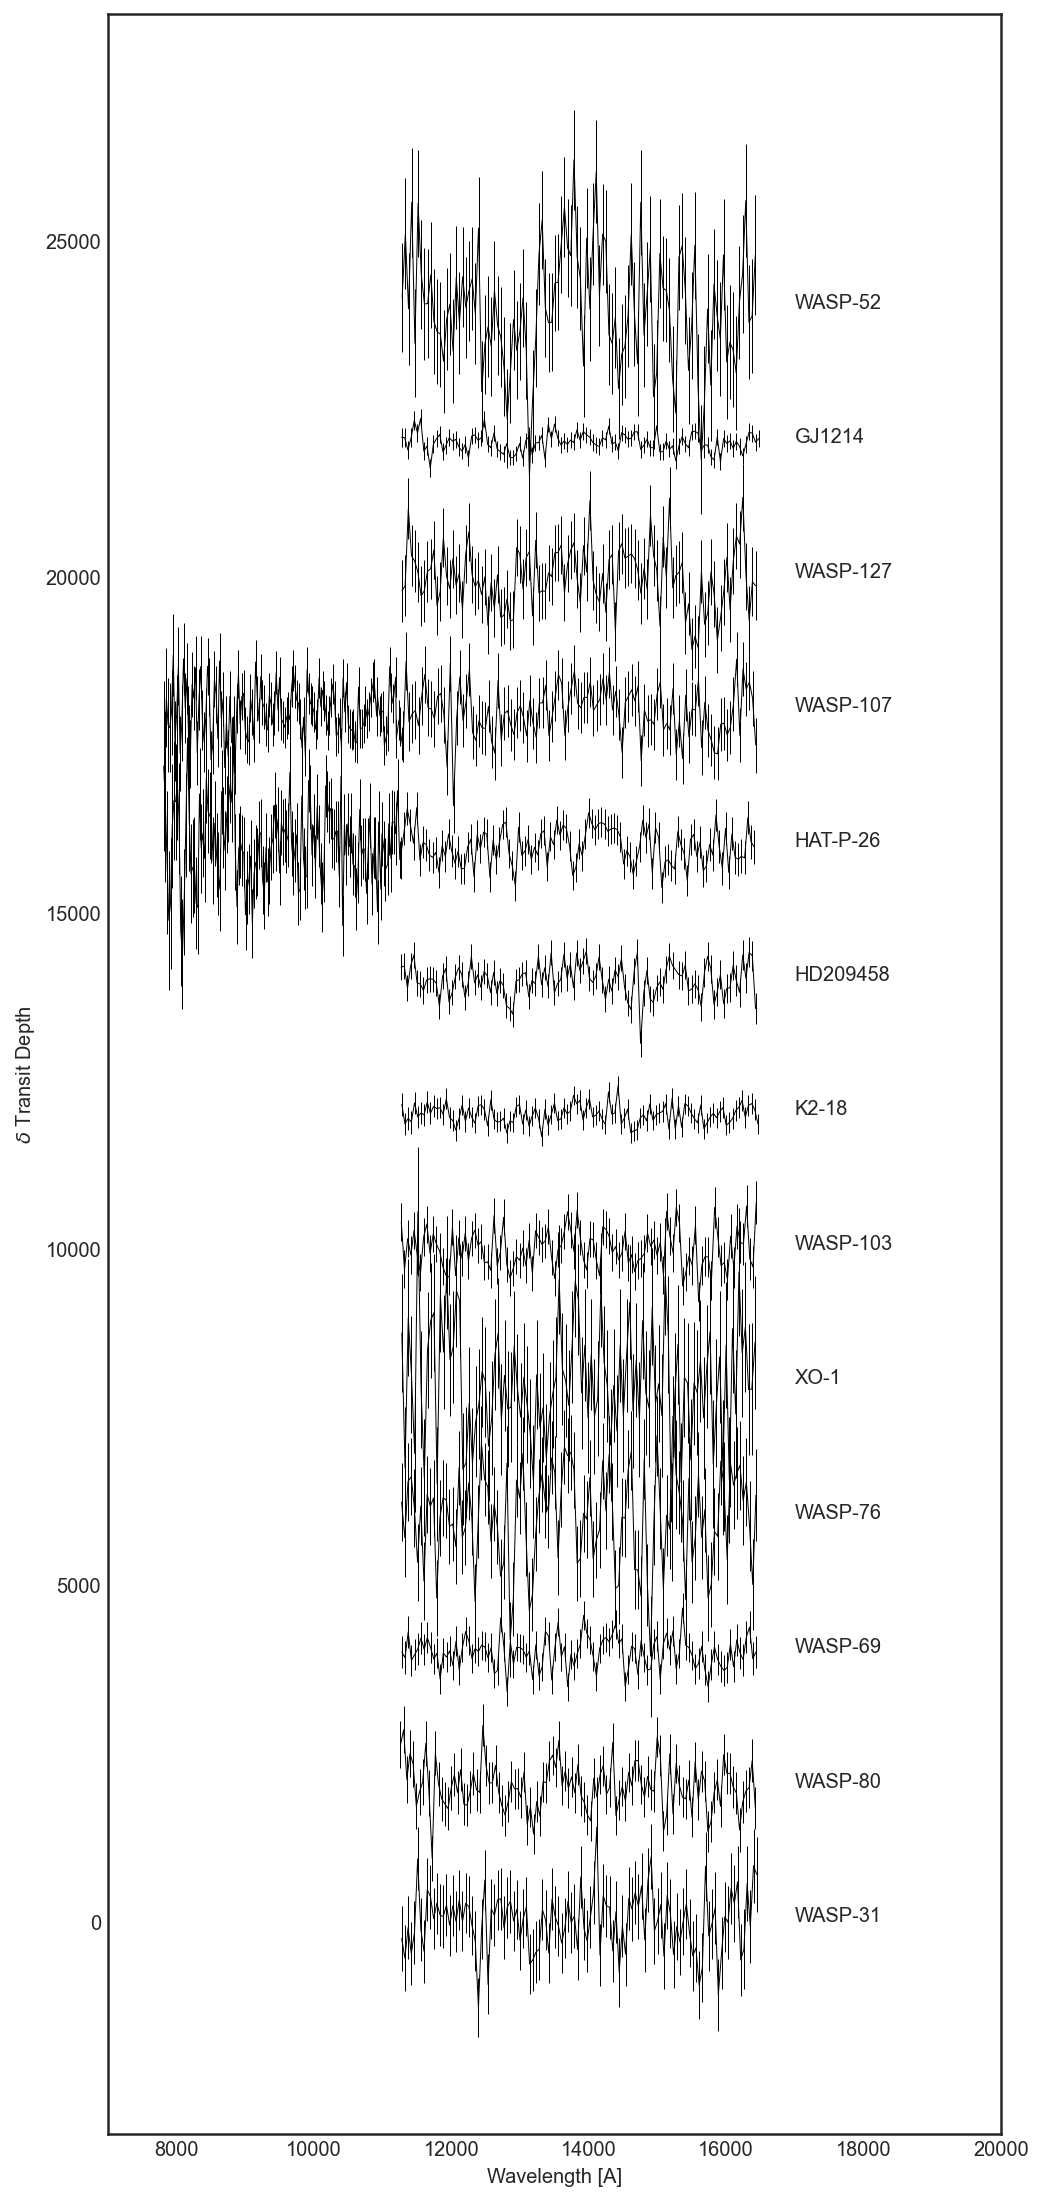

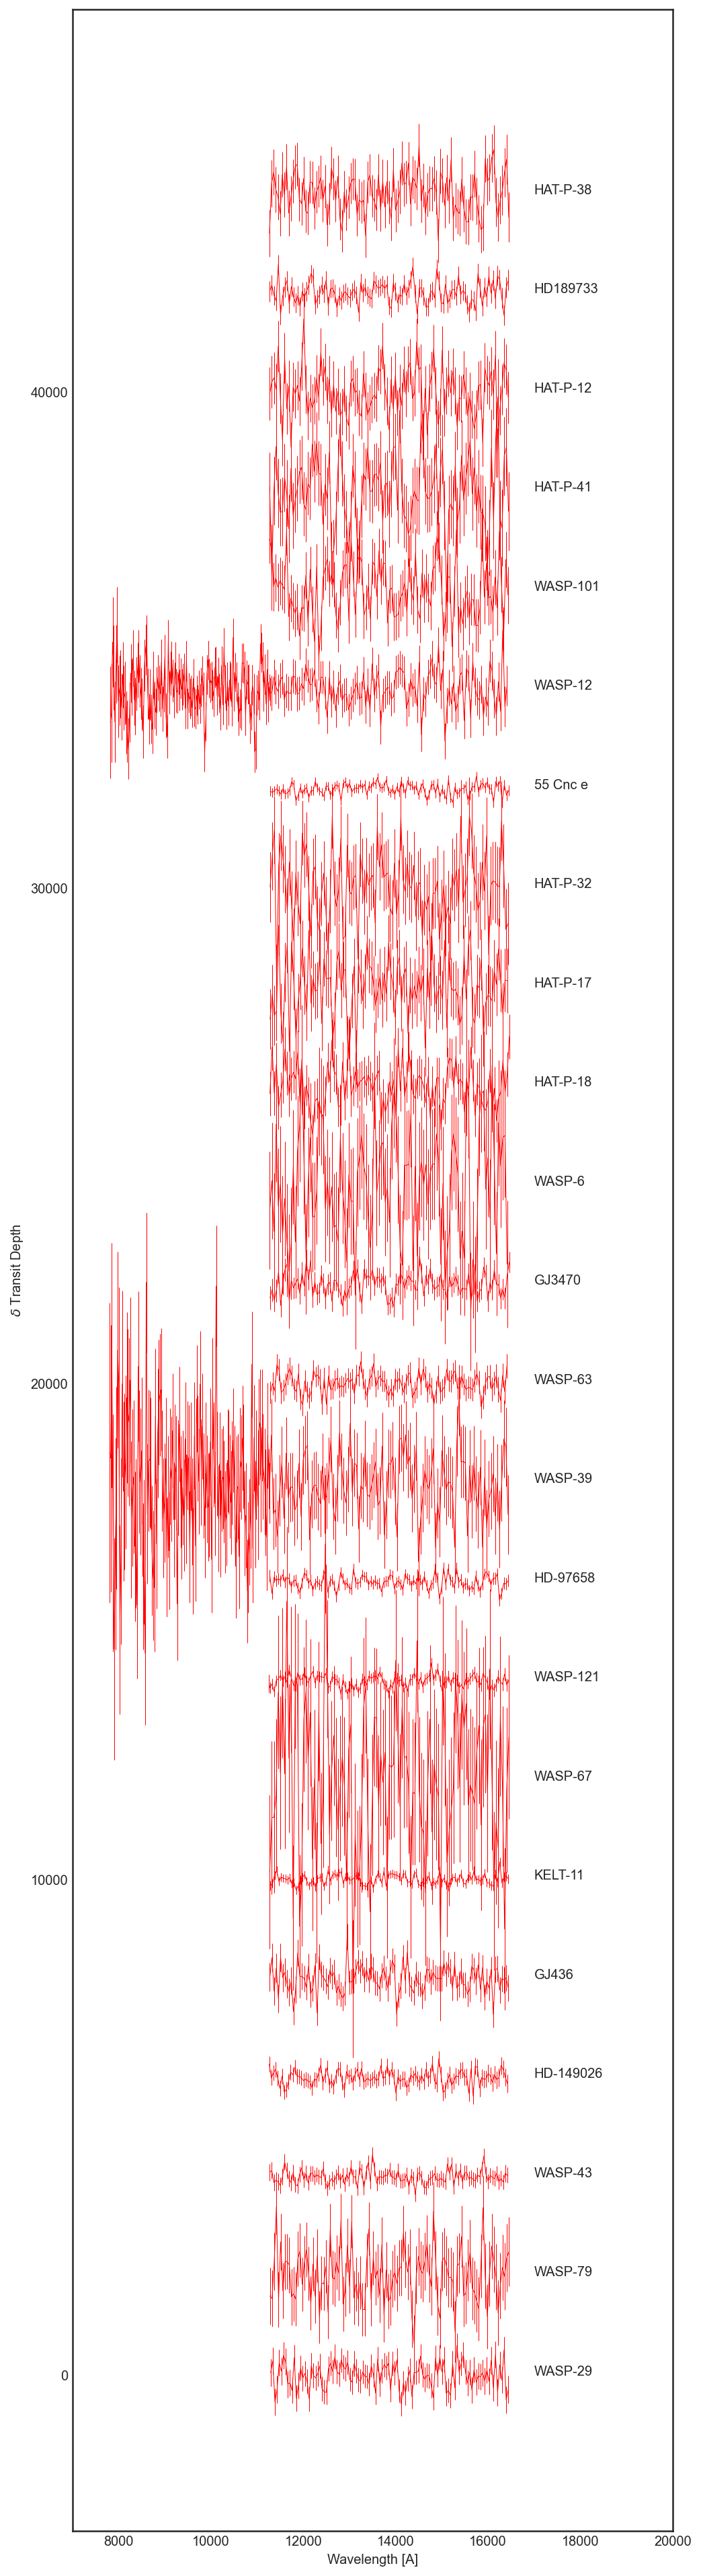

In [52]:
df1 = pd.concat([df, spare.rename({0:'planet'}, axis='columns')]).drop_duplicates('planet').sort_values(10)
df1 = df1[(df1['ch_corr']/df1['ch_corr_err']) > 1.5].reset_index(drop=True)

plt.figure(facecolor='white', figsize=(8, (len(df1)) * 1.5))
for idx, planet in enumerate(np.asarray(df1['planet'][np.argsort(df1['ch_corr']/df1['ch_corr_err'])])):
    r = pickle.load(open(f'results/{planet}/{planet}_results.p', 'rb'))
    w, t, te = r['transmission_wavelength'], r['transmission_spectrum'], r['transmission_spectrum_err']
    s = np.argsort(w)
    w, t, te = w[s], t[s], te[s]
    plt.errorbar(w, t + idx * 2000, te, c='k', lw=0.5)
#    plt.errorbar([i.mean() for i in np.array_split(w, 20)],
#                 np.asarray([np.nanmean(i) for i in np.array_split(t, 20)]) + idx * 1500,
#                 [(np.nansum(i**2)**0.5)/len(i) for i in np.array_split(te, 20)], c='r')
    plt.text(17000, 2000*idx, f'{r["name"]}')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('$\delta$ Transit Depth')
    
plt.xlim(7000, 20000)

df1 = pd.concat([df, spare.rename({0:'planet'}, axis='columns')]).drop_duplicates('planet').sort_values(10)
df1 = df1[(df1['ch_corr']/df1['ch_corr_err']) <= 1.5].reset_index(drop=True)

plt.figure(facecolor='white', figsize=(8, (len(df1)) * 1.5))
for idx, planet in enumerate(np.asarray(df1['planet'][np.argsort(df1['ch_corr']/df1['ch_corr_err'])])):
    r = pickle.load(open(f'results/{planet}/{planet}_results.p', 'rb'))
    w, t, te = r['transmission_wavelength'], r['transmission_spectrum'], r['transmission_spectrum_err']
    s = np.argsort(w)
    w, t, te = w[s], t[s], te[s]
    plt.errorbar(w, t + idx * 2000, te, c='r', lw=0.5)
#    plt.errorbar([i.mean() for i in np.array_split(w, 20)],
#                 np.asarray([np.nanmean(i) for i in np.array_split(t, 20)]) + idx * 1500,
#                 [(np.nansum(i**2)**0.5)/len(i) for i in np.array_split(te, 20)], c='r')
    plt.text(17000, 2000*idx, f'{r["name"]}')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('$\delta$ Transit Depth')
    
plt.xlim(7000, 20000)

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/core/f

Literature Correlation Significance: 0.09091961116357003
Hedges 2020 Correlation Significance: 0.1272658787362555


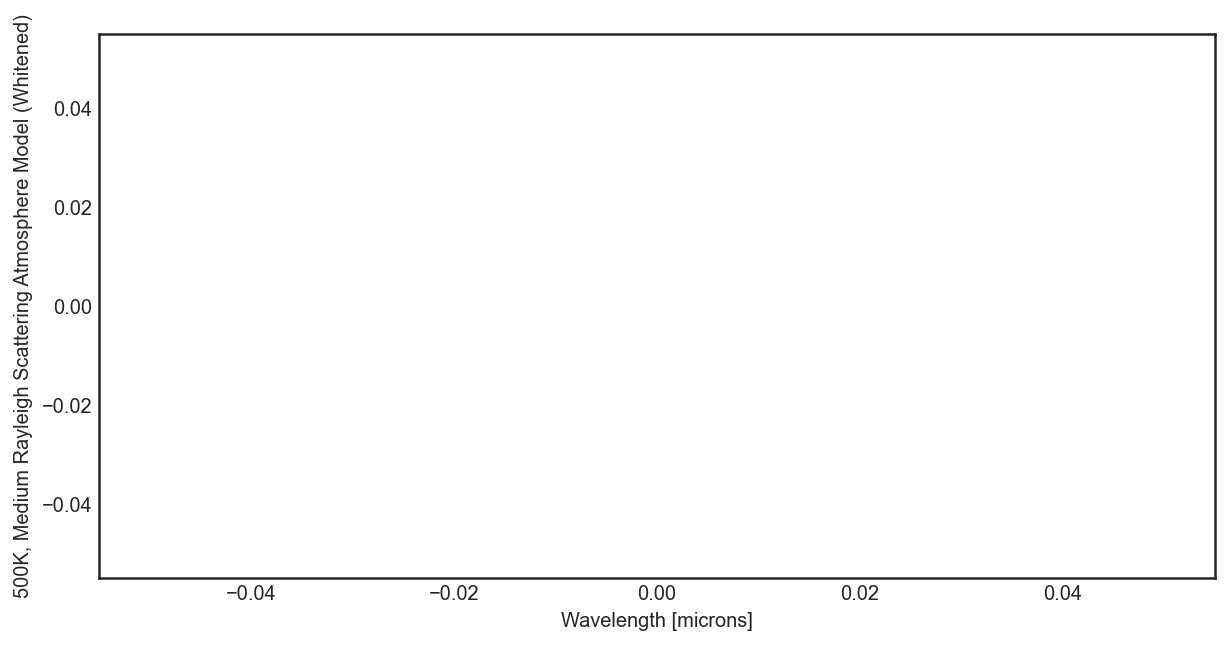

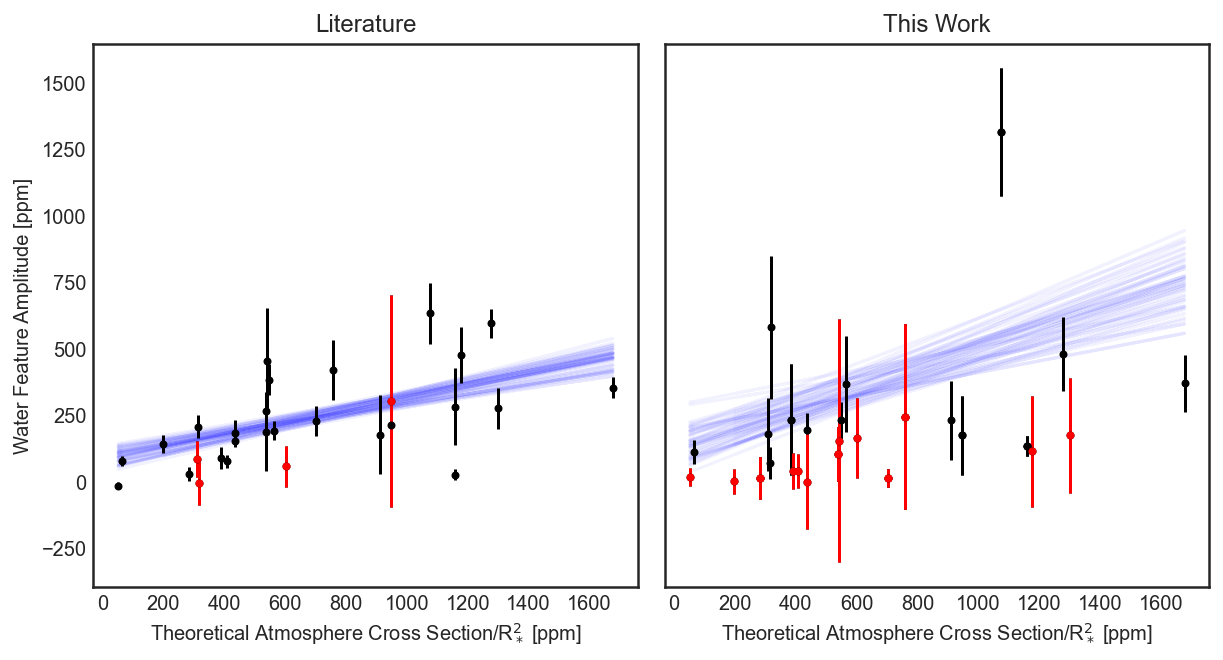

In [53]:

from scipy.stats import pearsonr
fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True, facecolor='white')

dw = np.median(np.diff(w))
smooth = convolve(fort[1], Gaussian1DKernel(20))
model = np.zeros(w.shape)

for kdx, w1 in enumerate(w):
    l = (fort[0] > (w1 - dw/2)) & (fort[0] <= (w1 + dw/2))
    model[kdx] = np.mean(smooth[l])
axs.plot(w, model, c='k')
axs.set(xlabel='Wavelength [microns]', ylabel='500K, Medium Rayleigh Scattering Atmosphere Model (Whitened)',)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, facecolor='white')

r1 = []
for i in range(50):
    samp = np.asarray(df['lit_corr'], float)  + np.random.normal(0, np.asarray(df['lit_corr_err'], float))
    a = np.vstack([np.asarray(df[10], float), samp])
    k = df['lit_flat'] == False
    r1.append(pearsonr(*a[:, k & (df1['planet'] != 'GJ1214')]))
    
    l = np.polyval(np.polyfit(np.asarray(df[10], float)[k], samp[k], 1), np.asarray(df[10], float))
    axs[0].plot(np.asarray(df[10], float) * 1e6, l, c='blue', alpha=0.05, zorder=-10)

axs[0].errorbar(np.asarray(df[10], float) * 1e6, df['lit_corr'], df['lit_corr_err'], ls='', marker='.', c='k')    
axs[0].errorbar(np.asarray(df[10], float)[~k] * 1e6, df['lit_corr'][~k], df['lit_corr_err'][~k], ls='', marker='.', c='r')    
r1 = np.asarray(r1)


r2 = []

df1 = pd.concat([df, spare.rename({0:'planet'}, axis='columns')]).drop_duplicates('planet').sort_values(10)
df1 = df
for i in range(50):
    samp = np.asarray(df1['ch_corr'], float)  + np.random.normal(0, np.asarray(df1['ch_corr_err'], float))
    a = np.vstack([np.asarray(df1[10], float), samp])
    k = (df1['ch_flat'] == False)
    r2.append(pearsonr(*a[:, k & (df['planet'] != 'GJ1214')]))
    
    l = np.polyval(np.polyfit(np.asarray(df1[10], float)[k & (df1['planet'] != 'GJ1214')], samp[k& (df1['planet'] != 'GJ1214')], 1), np.asarray(df1[10], float))
    axs[1].plot(np.asarray(df1[10], float) * 1e6, l, c='blue', alpha=0.05, zorder=-10)

axs[1].errorbar(np.asarray(df1[10], float) * 1e6, df1['ch_corr'], df1['ch_corr_err'], ls='', marker='.', c='k')    
axs[1].errorbar(np.asarray(df1[10], float)[~k] * 1e6, df1['ch_corr'][~k], df1['ch_corr_err'][~k], ls='', marker='.', c='r')    

#k = spare['ch_flat'] == False
#axs[1].errorbar(np.asarray(spare[10], float), spare['ch_corr'], spare['ch_corr_err'], ls='', marker='.', c='grey')    
#axs[1].errorbar(np.asarray(spare[10], float)[~k], spare['ch_corr'][~k], spare['ch_corr_err'][~k], ls='', marker='.', c='pink')    

#k = df1.planet == 'GJ1214'
#axs[1].text(np.asarray(df1[10], float)[k][0] * 1e6, np.asarray(df1['ch_corr'][k])[0], ' GJ1214b')


r2 = np.asarray(r2)


print('Literature Correlation Significance:', np.median(r1[:, 1]))
print('Hedges 2020 Correlation Significance:',np.median(r2[:, 1]))

axs[0].set(title=f"Literature") 
axs[1].set(title=f"This Work")

axs[0].set_ylabel("Water Feature Amplitude [ppm]")
#ax[0].set_xlabel("Atmosphere Cross Section [R$_{sol}^2$]")
axs[0].set_xlabel("Theoretical Atmosphere Cross Section/R$_*^2$ [ppm]")
axs[1].set_xlabel("Theoretical Atmosphere Cross Section/R$_*^2$ [ppm]")
plt.subplots_adjust(wspace=0.05)

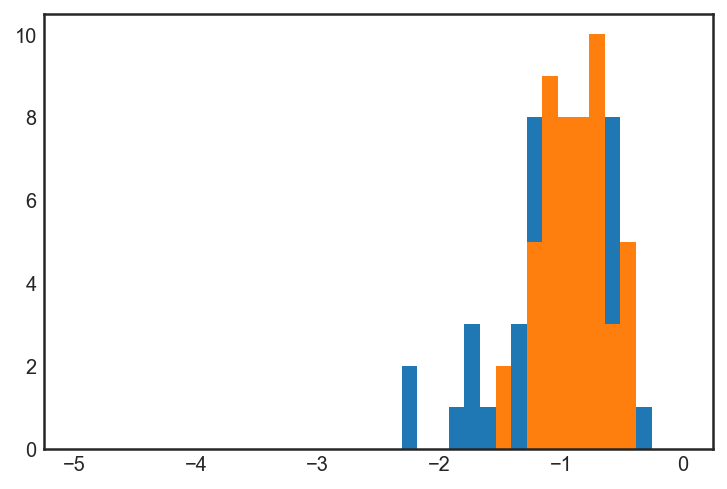

In [54]:
plt.hist(np.log10(r1[:, 1]), np.linspace(-5, 0, 40));
plt.hist(np.log10(r2[:, 1]), np.linspace(-5, 0, 40));

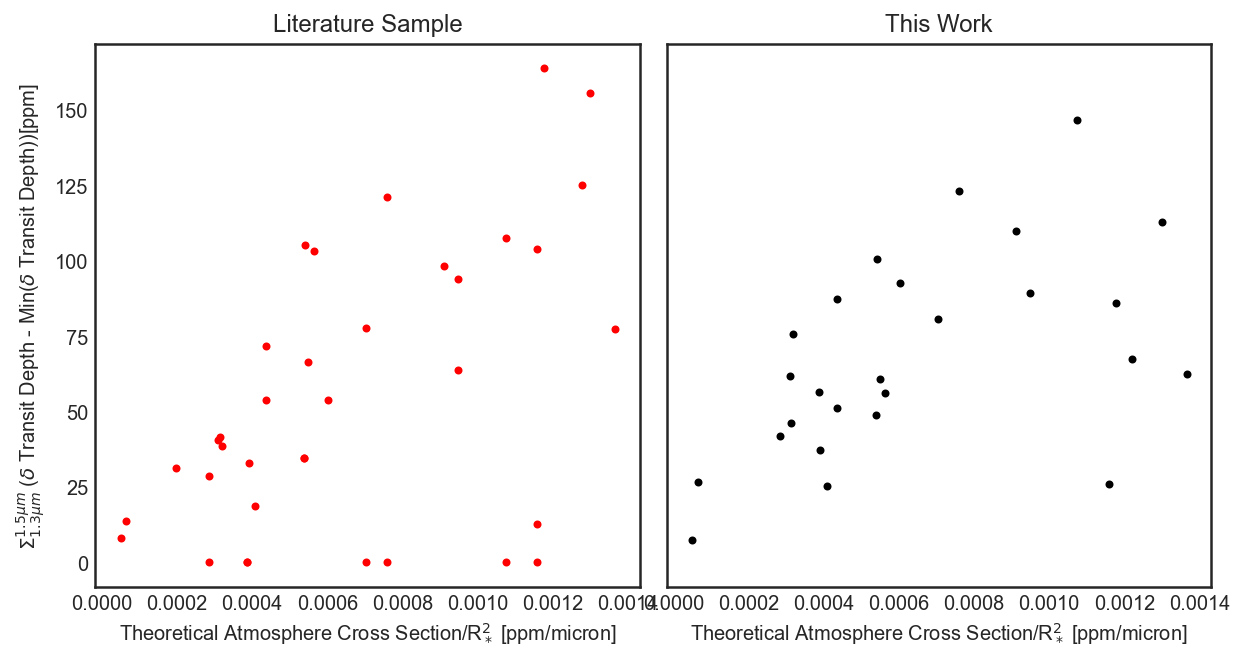

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, facecolor='white')
axs[0].errorbar(np.asarray(df[10], float), np.asarray(df['water'], float), ls='', marker='.', label='Literature', c='r')

temp = pd.read_csv('watery_temp.csv')
#axs[1].errorbar(np.asarray(temp['10'], float), np.asarray(temp['water'], float), ls='', marker='.', label='Hedges 2020', c='grey', alpha=0.4)
k = np.in1d(temp['0'], df.planet)
axs[1].errorbar(np.asarray(temp['10'], float)[k], np.asarray(temp['water'], float)[k], ls='', marker='.', label='Hedges 2020', c='k')

#plt.xlim(0, 4500)
#plt.ylim(-3000, 9500)
axs[0].set_ylabel("$\Sigma_{1.3\mu m}^{1.5\mu m}$ ($\delta$ Transit Depth - Min($\delta$ Transit Depth))[ppm]")
#ax[0].set_xlabel("Atmosphere Cross Section [R$_{sol}^2$]")
axs[0].set_xlabel("Theoretical Atmosphere Cross Section/R$_*^2$ [ppm/micron]")
axs[1].set_xlabel("Theoretical Atmosphere Cross Section/R$_*^2$ [ppm/micron]")
axs[0].set_title("Literature Sample")
axs[1].set_title("This Work")
plt.subplots_adjust(wspace=0.05)

In [79]:
df.merge(temp.rename({'0':'planet'}, axis='columns'), how='inner')

,planet,1,2,3,4,5,6,7,8,9,...,2,3,4,5,6,7,8,9,10,11


In [80]:
from scipy.stats import pearsonr
r1 = []
for i in range(50):
    samp = np.asarray(df['water'], float) * 1e6  + np.random.normal(0, np.asarray(df['water_err'], float) * 1e6)
    a = np.vstack([np.asarray(df[10], float) * 1e6, samp])
    a = a[:, a[1] > 0]
    r1.append(pearsonr(*a))
r1 = np.asarray(r1)


r2 = []
for i in range(50):
    samp = np.asarray(temp['water'], float) * 1e6  + np.random.normal(0, np.asarray(temp['water_err'], float) * 1e6)
    a = np.vstack([np.asarray(temp['10'], float) * 1e6, samp])
    a = a[:, a[1] > 0]
    r2.append(pearsonr(*a))
r2 = np.asarray(r2)


print('Literature Correlation Significance:', np.median(r1[:, 1]))
print('Hedges 2020 Correlation Significance:',np.median(r2[:, 1]))

#a = np.vstack([np.asarray(temp['10'], float) * 1e6, np.asarray(temp['water'], float) * 1e6])
#a = a[:, np.isfinite(a).all(axis=0)]
#print('Hedges 2020:', pearsonr(*a))

Literature Correlation Significance: 0.09916417381164036
Hedges 2020 Correlation Significance: 0.00010808762406359214


In [ ]:
plt.hist(np.log10(r1[:, 1]), np.linspace(-6, -1, 10), alpha=0.5)
plt.hist(np.log10(r2[:, 1]), np.linspace(-6, -1, 10), alpha=0.5)

In [ ]:
plt.hist((r1[:, 0]), np.linspace(0, 1, 30), alpha=0.5)
plt.hist((r2[:, 0]), np.linspace(0, 1, 30), alpha=0.5)

In [ ]:
df = pd.DataFrame([np.append(f.split('/')[-1].split('_'), f  + '?dl=1') for f in pd.read_csv('wakeford-cat.csv', header=None)[0]])
df = df[[0, 2, 3]]
df.columns = ['planet', 'text', 'url']
df.to_csv('wakeford-cat.csv', index=False)

In [ ]:
pd.read_csv(pd.read_csv('wakeford-cat.csv', header=None)[0][0], error_bad_lines=False)[140:]